In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds

import tensorflow as tf
tfds.disable_progress_bar()


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#import tensorflow as tf
import keras

In [0]:
solarpower = pd.read_csv("/content/drive/My Drive/Colab Notebooks/PV_Elec_Gas2.csv",header = None,skiprows=1 ,names = ['date','cum_power','Elec_kW', 
                                                                            'Gas_mxm'], sep=',',usecols = [0,1,2,3],
                     
                     parse_dates={'dt' : ['date']}, infer_datetime_format=True,index_col='dt')
print(solarpower.head(2))

            cum_power  Elec_kW  Gas_mxm
dt                                     
2011-10-26        0.1     15.1      9.0
2011-10-27       10.2      7.4      9.2


In [0]:
solarpower.shape

(2948, 3)

In [0]:
# make solar power stationary

solarpower2 = solarpower.shift(periods=1, freq='D', axis=0)
solarpower['cum_power_shift'] = solarpower2.loc[:,'cum_power']
solarpower['day_power'] = solarpower['cum_power'].values - solarpower['cum_power_shift']
solarpower.iloc[0:1].day_power.value = 0.
A = solarpower.dropna()
del A['cum_power'], A['cum_power_shift']
solarpower = A



In [0]:
print(solarpower2.head())

            cum_power  Elec_kW  Gas_mxm
dt                                     
2011-10-27        0.1     15.1      9.0
2011-10-28       10.2      7.4      9.2
2011-10-29       20.2      5.8      8.0
2011-10-30       29.6      4.9      6.6
2011-10-31       34.2     11.7      5.3


In [0]:
X_train = solarpower[:'2018-10-28']
X_valid = solarpower['2018-10-29':'2019-10-28'] # is 365 days
X_train.shape, X_valid.shape

((2559, 3), (365, 3))

In [0]:
X_train.tail(2), X_valid.head(2)

(            Elec_kW  Gas_mxm  day_power
 dt                                     
 2018-10-27     16.0      9.0        2.0
 2018-10-28      7.0     11.0        8.0,
             Elec_kW  Gas_mxm  day_power
 dt                                     
 2018-10-29     10.0     13.0        7.0
 2018-10-30     15.0     14.0        2.0)

In [0]:
X_valid_start_cum_power = solarpower2['2018-10-28':'2018-10-28'].cum_power.values
X_valid_start_cum_power # we need this to predict cumulative power on validation

array([28122.])

In [0]:
# dividing the series into multiple input and output patterns
 '''
    the series is split in (len(series)-window)-blocks of window size, 
    y is the next value that comes after the block, 
    every block starts with the next value in the series.
    The last block ends with the last-but-one value in the series.
    '''
def my_split_window(series, window):
   
    X = []
    y = []
    n_steps = len(series) - window
    for step in range(n_steps):
        X.append(series[step:window+step])
        y.append(series[step + window])
    X = np.array(X)
    y = np.array(y)
    return X, y


In [0]:
# test my_split_window
my_series = np.array([10,20,30,40,50,60,70,80,90])
X_, y_ = my_split_window(my_series, 3)
X_, y_


(array([[10, 20, 30],
        [20, 30, 40],
        [30, 40, 50],
        [40, 50, 60],
        [50, 60, 70],
        [60, 70, 80]]), array([40, 50, 60, 70, 80, 90]))

In [0]:
# apply my_split_window on dayly solar power with a window of 365 days 
# the input series is the daily solar power
train_power_series = X_train.day_power.values
window = 365
X, y = my_split_window(train_power_series, window)
# print a sample
for i in range(3):
    print(X[i][-5:], y[i])


[3.2 5.5 9.6 8.2 8.7] 1.5
[5.5 9.6 8.2 8.7 1.5] 2.0
[9.6 8.2 8.7 1.5 2. ] 9.200000000000273


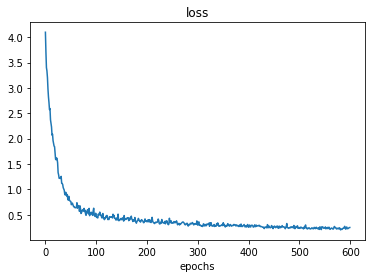

'# fit model\nkeras_model_path = "/tmp/keras_save"\nmodel.save(keras_model_path)  # save() should be called out of strategy scope\n\nhistory = tf.keras.models.load_model(keras_model_path)\nhistory = model.fit(X, y, epochs=600, verbose=0)\n#history = model.fit(X, y, epochs=200, verbose=0)\n\n# graph of the loss shows convergence\nimport matplotlib.pyplot as plt\nplt.plot(history.history[\'loss\'])\nplt.title(\'loss\')\nplt.xlabel(\'epochs\')\nplt.show() '

In [0]:
import warnings
warnings.filterwarnings("ignore")
# we have an input shape = window size, number of features 
# we use only 1 feature (it is univariate) and we have a window size of one year (365 days) 
# we have to reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu', 
                                 input_shape=(window, n_features)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mae')  # metrics=['mae'])
# fit model
keras_model_path = "/tmp/keras_save"
model.save(keras_model_path)  # save() should be called out of strategy scope

history = tf.keras.models.load_model(keras_model_path)
history = model.fit(X, y, epochs=600, verbose=0)
#history = model.fit(X, y, epochs=600, verbose=0)

# graph of the loss shows convergence
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.show()
'''# fit model
keras_model_path = "/tmp/keras_save"
model.save(keras_model_path)  # save() should be called out of strategy scope

history = tf.keras.models.load_model(keras_model_path)
history = model.fit(X, y, epochs=600, verbose=0)
#history = model.fit(X, y, epochs=200, verbose=0)

# graph of the loss shows convergence
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.show() '''

In [0]:
# predicting next year
x_input = np.array(X_train.day_power[-365:]) #  next value based on data of last year
x_input = x_input.reshape((1, window, n_features)) 

for i in range(365):
    y_hat = model.predict(x_input, verbose=0)
    new_x = y_hat.reshape((1,1,1))
    x_input = np.concatenate((x_input[:, -364:], new_x), axis=1)
x_input.shape


(1, 365, 1)

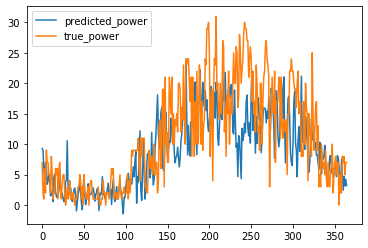

In [0]:
y_predicted = x_input.reshape((x_input.shape[1]))
plt.plot(y_predicted, label='predicted_power')

y_true = X_valid.day_power.values
plt.plot(y_true, label='true_power')
plt.legend()
plt.show()

In [0]:
pred_int = np.array(y_predicted, dtype='int')

In [0]:
pred_list = pred_int.tolist()
print(pred_list)

[9, 8, 6, 4, 6, 6, 3, 3, 5, 3, 1, 2, 1, 0, 4, 5, 2, 1, 1, 1, 2, 5, 2, 1, 1, 1, 0, 1, 3, 4, 10, 2, 1, 2, 2, 1, 0, 1, 2, 2, 1, 0, 0, 1, 2, 3, 2, 0, 0, 2, 4, 1, 0, 1, 1, 3, 2, 1, 1, 2, 2, 2, 2, 0, 1, 2, 2, 1, 0, 1, 1, 2, 4, 1, 2, 1, 1, 1, 2, 3, 1, 2, 2, 0, 2, 4, 2, 0, 1, 3, 1, 0, 2, 3, 2, 2, 0, -1, 1, 1, 2, 4, 2, 5, 4, 3, 3, 3, 4, 6, 4, 7, 8, 0, 4, 3, 8, 12, 2, 0, 4, 10, 6, 0, 2, 6, 8, 8, 7, 4, 6, 11, 5, 3, 4, 9, 11, 14, 18, 11, 9, 9, 15, 16, 6, 5, 6, 13, 15, 9, 7, 9, 10, 10, 14, 12, 10, 13, 8, 6, 7, 8, 9, 7, 6, 7, 10, 11, 14, 14, 13, 16, 24, 13, 8, 13, 9, 8, 13, 12, 15, 14, 16, 20, 14, 8, 16, 16, 17, 22, 12, 15, 20, 17, 16, 18, 15, 17, 13, 12, 14, 15, 19, 17, 13, 15, 18, 14, 20, 18, 10, 9, 12, 16, 14, 14, 17, 20, 17, 21, 15, 15, 17, 19, 19, 17, 19, 19, 12, 11, 18, 13, 9, 10, 4, 11, 11, 7, 4, 12, 10, 11, 13, 11, 17, 18, 12, 11, 13, 10, 18, 21, 12, 13, 15, 8, 14, 10, 17, 16, 13, 14, 8, 11, 14, 15, 15, 15, 13, 15, 14, 17, 15, 12, 19, 17, 16, 12, 7, 14, 18, 17, 11, 9, 10, 16, 20, 18, 14, 21,

In [0]:
true_list = y_true.tolist()

In [0]:
df = pd.DataFrame()
df['TRUE']  = y_true
df['PREDICTED']  = pred_int

df.head(), df.shape

(   TRUE  PREDICTED
 0   7.0          9
 1   2.0          8
 2   1.0          6
 3   6.0          4
 4   2.0          6, (365, 2))

In [0]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_pred - y_true) / y_pred)) 

In [0]:
for index, row in df.iterrows():

  a = mean_absolute_percentage_error(row['TRUE'], row['PREDICTED'])

  print(a) 

0.2222222222222222
0.75
0.8333333333333334
0.5
0.6666666666666666
0.5
1.3333333333333333
1.3333333333333333
0.0
0.6666666666666666
1.0
3.0
4.0
inf
0.5
0.6
2.0
4.0
5.0
0.0
2.0
0.4
0.0
0.0
3.0
4.0
inf
1.0
1.0
0.75
0.7
0.5
1.0
1.0
0.5
1.0
inf
1.0
0.5
1.0
0.0
inf
inf
2.0
0.5
0.6666666666666666
1.0
inf
inf
1.0
0.25
1.0
inf
0.0
0.0
0.0
1.0
2.0
3.0
1.0
0.0
0.5
0.5
inf
0.0
0.5
0.5
2.0
inf
1.0
1.0
0.5
0.75
3.0
0.0
1.0
1.0
1.0
0.0
0.3333333333333333
0.0
0.0
1.0
inf
1.5
0.5
0.5
inf
1.0
0.6666666666666666
1.0
inf
0.5
0.6666666666666666
0.0
0.5
inf
3.0
2.0
1.0
0.0
0.5
1.5
0.8
0.0
0.3333333333333333
0.3333333333333333
2.0
1.0
0.5
1.25
0.2857142857142857
0.125
inf
1.25
2.6666666666666665
0.25
0.6666666666666666
4.5
inf
1.75
0.1
0.8333333333333334
inf
0.5
0.6666666666666666
0.75
0.125
0.2857142857142857
0.5
0.0
0.2727272727272727
0.0
1.3333333333333333
1.5
0.4444444444444444
0.36363636363636365
0.5
0.8888888888888888
0.6363636363636364
0.4444444444444444
0.5555555555555556
0.6
0.375
2.1666666666666665

In [0]:
print(abs(a.mean()))

1.3333333333333333


In [0]:
first_r2_score = r2_score(y_true, y_predicted) # Best possible score is 1.0 
first_mae = mean_absolute_error(y_true, y_predicted)
print('r2_score %.4f' % first_r2_score)
print('mae %.2f' % first_mae)

r2_score 0.3908
mae 4.73


In [0]:
import math
rootmse = np.sqrt(mean_squared_error(y_true, pred_int))
print(rootmse)

6.559318374209822


In [0]:
df_proj = pd.DataFrame({'TRUE': y_true, 'PREDICTED': y_predicted})
df_proj = df_proj.to_csv(r'/content/drive\pred.csv')

In [0]:
#Cululative power tells us the expected solar power of the year
def cumulate(series, start=0):
    '''
    start is the starting cumulative power, the series is the daily solar power
    a list with daily cumulative power is the result
    '''
    cum = [start]
    for i in range(len(series)):
        sum_plus = cum[i] + series[i]
        cum.append(sum_plus)
    return cum

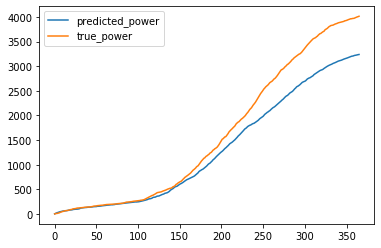

In [0]:
y_true_cumulative = cumulate(y_true)
y_predicted_cumulative = cumulate(y_predicted)

plt.plot(y_predicted_cumulative, label='predicted_power')
plt.plot(y_true_cumulative, label='true_power')
plt.legend()
plt.show()



* The error increases after 4 months

In [0]:
import math
true_cumulative_power_after_one_year = int(y_true_cumulative[-1])
predicted_cumulative_power_after_one_year = int(y_predicted_cumulative[-1])
print('true cumulative power after one year:', true_cumulative_power_after_one_year)
print('predicted cumulative power after one year:', predicted_cumulative_power_after_one_year)

acc_one_year = 1- (true_cumulative_power_after_one_year - predicted_cumulative_power_after_one_year)/true_cumulative_power_after_one_year
acc_one_year = acc_one_year * 100

print('accuracy after one year: %.2f' %  acc_one_year,'%')
print('r2 score %.2f ' % r2_score(y_true_cumulative, y_predicted_cumulative))
print('mae  %.2f' % mean_absolute_error(y_true_cumulative, y_predicted_cumulative))
print('rmse  %.2f' % mean_squared_error(y_true_cumulative, y_predicted_cumulative, squared=False))
print('mape  %.2f' % mean_absolute_percentage_error(y_true_cumulative, y_predicted_cumulative))





true cumulative power after one year: 4015
predicted cumulative power after one year: 3238
accuracy after one year: 80.65 %
r2 score 0.91 
mae  291.17
rmse  414.19
mape  nan


In [0]:
#using y_hat to train the model again for every day
# predicting next year
x_input = np.array(X_train.day_power[-365:]) #  next value based on data of last year
x_input = x_input.reshape((1, window, n_features))
y_hat = model.predict(x_input, verbose=0)
for i in range(365):
    new_x = y_hat.reshape((1,))
    train_power_series = np.concatenate((train_power_series, new_x), axis=0)
    X, y = my_split_window(train_power_series, window)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    history = model.fit(X, y, epochs=3, verbose=0)
    x_input = train_power_series[-365:]
    x_input = x_input.reshape((1, window, n_features))
    y_hat = model.predict(x_input, verbose=0)
    if i % 40 ==0:
        print('at i=', i, 'y_hat',y_hat)

at i= 0 y_hat [[9.000828]]
at i= 40 y_hat [[-0.85707974]]
at i= 80 y_hat [[2.3944407]]
at i= 120 y_hat [[10.058862]]
at i= 160 y_hat [[7.875971]]
at i= 200 y_hat [[15.919323]]
at i= 240 y_hat [[10.838979]]
at i= 280 y_hat [[17.829464]]
at i= 320 y_hat [[11.158907]]
at i= 360 y_hat [[4.7885137]]


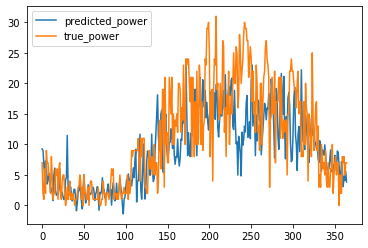

In [0]:
y_predicted = x_input.reshape((x_input.shape[1]))
plt.plot(y_predicted, label='predicted_power')

y_true = X_valid.day_power.values
plt.plot(y_true, label='true_power')
plt.legend()
plt.show()


In [0]:
r2_score(y_true, y_predicted) # Best possible score is 1.0 

0.4012068710438651

In [0]:
mae = mean_absolute_error(y_true, y_predicted)
print('mae %.2f' % mae)

mae 4.69


In [0]:
rmse = mean_squared_error(y_true, y_predicted, squared=False)
rmse

6.329173726688596

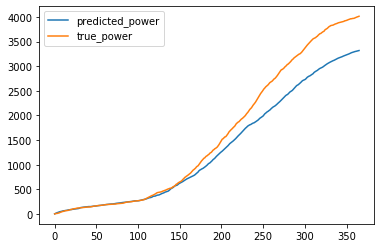

In [0]:
y_true_cumulative = cumulate(y_true)
y_predicted_cumulative = cumulate(y_predicted)

plt.plot(y_predicted_cumulative, label='predicted_power')
plt.plot(y_true_cumulative, label='true_power')
plt.legend()
plt.show()

In [0]:
true_cumulative_power_after_one_year = int(y_true_cumulative[-1])
predicted_cumulative_power_after_one_year = int(y_predicted_cumulative[-1])
print('true cumulative power after one year:', true_cumulative_power_after_one_year)
print('predicted cumulative power after one year:', predicted_cumulative_power_after_one_year)

acc_one_year = 1- (true_cumulative_power_after_one_year - predicted_cumulative_power_after_one_year)/true_cumulative_power_after_one_year
acc_one_year = acc_one_year * 100

print('accuracy after one year: %.2f' %  acc_one_year,'%')
print('r2 score %.2f ' % r2_score(y_true_cumulative, y_predicted_cumulative))
print('mae  %.2f' % mean_absolute_error(y_true_cumulative, y_predicted_cumulative))
print('rmse  %.2f' % mean_squared_error(y_true_cumulative, y_predicted_cumulative, squared=False))
print('mape  %.2f' % mean_absolute_percentage_error(y_true_cumulative, y_predicted_cumulative))



true cumulative power after one year: 4015
predicted cumulative power after one year: 3318
accuracy after one year: 82.64 %
r2 score 0.92 
mae  272.14
rmse  390.83
mape  nan


In [0]:
%pylab inline

import os
import numpy as np
import pandas as pd
#from scipy.misc import imread
#from scipy.ndimage import imread
#from scipy.misc.pilutil import imread
from matplotlib.pyplot import imread
'''To read jpg images without PIL use:
import cv2 as cv
im = cv.imread(image.jpg)'''
from sklearn.metrics import accuracy_score
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, Flatten, MaxPooling2D, Reshape, InputLayer

Populating the interactive namespace from numpy and matplotlib


In [0]:
#set seed value
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

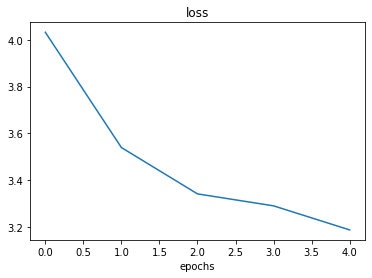

In [0]:
#change our model to be “wide”, i.e. increase the number of neurons in our hidden layer

# define vars
input_num_units = 784
hidden_num_units = 500
output_num_units = 10
epochs = 5
batch_size = 128

'''model = Sequential([
 Dense(output_dim=hidden_num_units, input_dim=input_num_units, activation='relu'),

 Dense(output_dim=output_num_units, input_dim=hidden_num_units, activation='softmax'),
])'''

import warnings
warnings.filterwarnings("ignore")

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu', 
                                 input_shape=(window, n_features, )))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
Dense(output_dim=hidden_num_units, input_dim=input_num_units, activation='relu'),
Dense(output_dim=output_num_units, input_dim=hidden_num_units, activation='softmax')
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])  # metrics=['mae'])
# fit model
keras_model_path = "/tmp/keras_save"
model.save(keras_model_path)  # save() should be called out of strategy scope

history = tf.keras.models.load_model(keras_model_path)
history = model.fit(X, y, epochs=epochs, verbose=0)
#history = model.fit(X, y, epochs=600, verbose=0) 

# graph of the loss shows convergence
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.show()